In [ ]:
Heigon <Sobrenome>    <RA>                      Rafael Galib  204904

# Introdução

 Nesta atividade nos foi dada a incumbência de implementar métodos não supervisionados para agrupamento em bases de dados. No contexto da atividade, chamaremos agrupamento por clusterzisação,termo advindo do neologismo.
    Os objetivos constiuem-se de:
        - Implementar o método k-means, que será abordado mais adiante
        - Implementar um método a nossa escolha, no caso DBScan
        - Tratar os dados contidos na base fornecida pela Professora, assim como a de nossa escolha
        - Averiguar, por meio de métricas, quais configurações iniciais seriam as mais adequadas
        - Executar os dois métodos para a base da Professora
        - Executar apenas k-means para a base de nossa escolha, uma vez com os dados tratados por nós mesmos e uma vez utilizando PCA nos dados tratados.

# Imports

    Nesta seção são importadas todas as bibliotecas desejadas para a execução da atividade.

In [19]:
%matplotlib inline 
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import numpy as np
import itertools
import collections
import queue
import scipy.io as spio

# Função aLabel

A função aLabel (lê-se: assign label) utiliza de uma sequência de dados X, assim como centros previamente definidos.

In [20]:
def aLabel(X, centers):
    # dist = np.array([[np.sqrt(np.square(x[0]-y[0]) + np.square(x[1]-y[1])) for x in centers] for y in X])
    dist = np.array([[np.linalg.norm(x - y) for x in centers] for y in X])
    mins = np.array([m.min() for m in dist]).T

    labs = np.array([np.where(mins[i] == dist[i]) for i in range(len(mins))]).T

    return labs[0][0]

# K-means

Aqui encontra-se nossa implementação do k-means. Temos, para um número predefinido de clusters, a associação dos pontos do conjunto X ao grupo cujo centro se encontra mais próximo em distância. Ao final de cada iteração do método, temos novos centros sendo definidos, o que nos faz esperar que uma convergência esteja ocorrendo. Uma vez verificada a convergência, o método interrompe-se.

In [21]:

def Kmeans(X, n_clusters):
    # 1. Randomly choose clusters
    solving = True 
    rng = np.random.RandomState(2)
    i = rng.permutation(X.shape[0])[:n_clusters]
    centers = X[i]
    
    while solving:
        # 2a. Assign labels based on closest center
        labels = aLabel(X, centers)
        
        # 2b. Find new centers from means of points
        new_centers = np.array([X[labels == i].mean(0)
                                for i in range(n_clusters)])
        
        # 2c. Check for convergence
        if np.all(centers == new_centers):
            solving = False
        centers = new_centers
    
    return centers, labels

# Min Max

Este método serve para normalizar as dimensões de uma base de dados. Para cada dimensão, normalizamos todos os valores baseados no valor máximo e no valor mínimo. Para tanto, utilizamos a fórmula: ( new_val = old_val \* md \* scale /  Md - md ), onde Md e md são o valor máximo e o mínimo, respectivamente, de uma dada dimensão, e scale é um valor arbitrário para o qual se deseja que seja o novo máximo.

In [22]:

def MinMax(xy):
    features = []
    results = []
    newXY = []

    for i in range(len(xy[0])):
        aux1 = []
        aux2 = []
        for j in range(len(xy)):
            aux1.append(xy[j][i])
            aux2.append(xy[j][i])
        features.append(aux1)
        results.append(aux2)


    for i in range(len(features)):
        for j in range(len(features[i])):
            results[i][j] = ((features[i][j] - min(features[i])) * 30) / (max(features[i])-min(features[i]))

    for i in range(len(results)):
        for j in range(len(results[i])):
            if i == 0:
                aux = [results[i][j]]
                newXY.append(aux)
            else:
                newXY[j].append(results[i][j])
                
    return np.array(newXY)
    

# Lendo cluster.dat

In [23]:
with open('cluster.dat') as f:
    lines = f.readlines()
    xy = np.array([[float(line.split()[0]),float(line.split()[1])] for line in lines])

# Normalizando cluster.dat

In [24]:
xy = MinMax(xy)

# Separação treinamento e teste

In [25]:

def dataSplit(dataset):
    p90 = int(len(dataset)* 90/100)

    rng = np.random.RandomState(15)
    i = rng.permutation(dataset.shape[0])

    Points_Training =dataset[i[:p90]]
    Points_Test=dataset[i[p90:len(dataset)]]

    return Points_Training,Points_Test



# Plotando cluster.dat

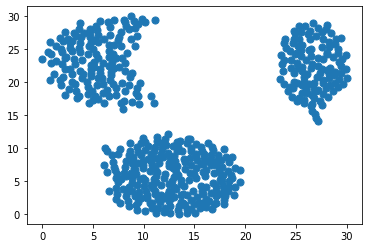

In [26]:
PointsTrainingK1,PointsTestK1 = dataSplit(xy)
plt.scatter(PointsTrainingK1[:, 0], PointsTrainingK1[:, 1], s=50)
plt.show()

# Método Cotovelo

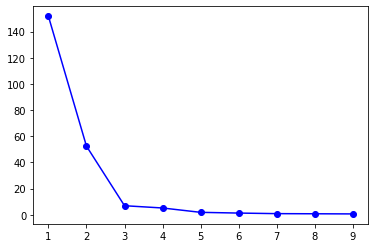

In [27]:
temp_epsilon = []
num_cluster = range(1,10)
for k in num_cluster:
    centersK1, labelsK1 = Kmeans(PointsTrainingK1, k)
    # plt.scatter(PointsTrainingK1[:, 0], PointsTrainingK1[:, 1], c=labels,s=50, cmap='viridis')
    # plt.show()
    for p in range(k):
        n=0
        for x in centersK1: 
            z=0
            for i in range(len(labelsK1)):
                if labelsK1[i] == p:
                    # z += np.square(PointsTrainingK1[i][0] - x[0]) + np.square(PointsTrainingK1[i][1] - x[1])
                    z += np.linalg.norm(PointsTrainingK1[i] - x)**2
                    n+=1   
    temp_epsilon.append(z/n)


plt.plot(num_cluster,temp_epsilon,"bo-")
plt.show()

# Kmeans no cluster.dat

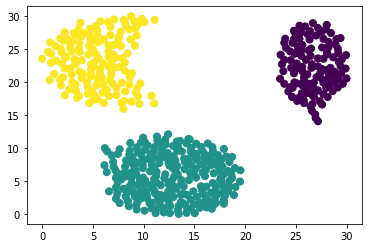

In [28]:
centersK1, labelsK1 = Kmeans(PointsTrainingK1, 3)
plt.scatter(PointsTrainingK1[:, 0], PointsTrainingK1[:, 1], c=labelsK1,s=50, cmap='viridis')
plt.show()

# Teste Kmeans

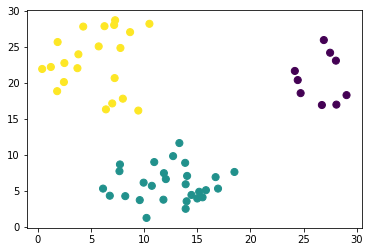

In [29]:
labelsTestK1 = aLabel(PointsTestK1, centersK1)
plt.scatter(PointsTestK1[:, 0], PointsTestK1[:, 1], c=labelsTestK1,s=50, cmap='viridis')
plt.show()

# Função para encontrar pontos vizinhos

In [30]:
def neighbor_points(data, pointId, radius):
    points = []
    for i in range(len(data)):
        if np.linalg.norm(data[i] - data[pointId]) <= radius:
            points.append(i)
    return points

# Implementação DBScan

In [31]:


def DBScan(dataSet, radius, minPt):

    core = -1
    edge = -2

    
    pointLabel  = [0] * len(dataSet)
    pointCount = []
    corePoint=[]
    nonCore=[]
    
    for i in range(len(dataSet)):
        pointCount.append(neighbor_points(dataSet,i,radius))
    
    for i in range(len(pointCount)):
        if (len(pointCount[i])>=minPt):
            pointLabel[i]=core
            corePoint.append(i)
        else:
            nonCore.append(i)

    for i in nonCore:
        for j in pointCount[i]:
            if j in corePoint:
                pointLabel[i]=edge
                break
            
    cluster = 1
    for i in range(len(pointLabel)):
        q = queue.Queue()
        if (pointLabel[i] == core):
            pointLabel[i] = cluster
            for x in pointCount[i]:
                if(pointLabel[x]==core):
                    q.put(x)
                    pointLabel[x]=cluster
                elif(pointLabel[x]==edge):
                    pointLabel[x]=cluster 
            while not q.empty():
                neighbors = pointCount[q.get()]
                for y in neighbors:
                    if (pointLabel[y]==core):
                        pointLabel[y]=cluster
                        q.put(y)
                    if (pointLabel[y]==edge):
                        pointLabel[y]=cluster            
            cluster+=1
           
    return pointLabel,cluster

# Função para plotar DBScan bonito

In [32]:
def plotRes(data, clusterRes, clusterNum):
    nPoints = len(data)
    scatterColors = ['black', 'green', 'brown', 'red', 'purple', 'orange', 'yellow']
    for i in range(clusterNum):
        if (i==0):
            color='blue'
        else:
            color = scatterColors[i % len(scatterColors)]
        x1 = [];  y1 = []
        for j in range(nPoints):
            if clusterRes[j] == i:
                x1.append(data[j, 0])
                y1.append(data[j, 1])
        plt.scatter(x1, y1, c=color, alpha=1, marker='.')

# Vários DBScan rodando

In [33]:
PointsTrainingDB1,PointsTestDB1 = dataSplit(xy)

In [34]:
epss = 10
minptss = 10

Leps = []
Lminpts = []
Lcluster = []
Lout = []

for eps in range(1,epss):
    for minpts in range(2,minptss):
        print('Set eps = ' +str(eps)+ ', Minpoints = '+str(minpts))
        pointlabelDB1,clustersB1 = DBScan(PointsTrainingDB1,eps,minpts)
        # plotRes(PointsTrainingDB1, pointlabelDB1, clustersB1)
        # plt.show()
        print('number of cluster found: ' + str(clustersB1-1))
        counter=collections.Counter(pointlabelDB1)
        print(counter)
        outliers  = pointlabelDB1.count(0)
        print('number of outliers found: '+str(outliers) +'\n')
        Leps.append(eps)
        Lminpts.append(minpts)
        Lcluster.append(clustersB1-1)
        Lout.append(outliers)



Set eps = 1, Minpoints = 2
number of cluster found: 7
Counter({1: 239, 2: 133, 3: 121, 0: 8, 4: 5, 6: 5, 5: 2, 7: 2})
number of outliers found: 8

Set eps = 1, Minpoints = 3
number of cluster found: 5
Counter({1: 239, 2: 133, 3: 121, 0: 12, 4: 5, 5: 5})
number of outliers found: 12

Set eps = 1, Minpoints = 4
number of cluster found: 8
Counter({1: 238, 2: 112, 3: 99, 0: 31, 4: 16, 5: 11, 7: 3, 8: 3, 6: 2})
number of outliers found: 31

Set eps = 1, Minpoints = 5
number of cluster found: 13
Counter({1: 234, 0: 82, 5: 42, 3: 36, 2: 30, 8: 17, 7: 15, 9: 14, 6: 10, 10: 10, 13: 8, 4: 7, 11: 7, 12: 3})
number of outliers found: 82

Set eps = 1, Minpoints = 6
number of cluster found: 14
Counter({1: 216, 0: 136, 4: 40, 6: 24, 9: 14, 2: 13, 10: 12, 3: 11, 5: 11, 7: 8, 13: 7, 14: 6, 8: 6, 11: 6, 12: 5})
number of outliers found: 136

Set eps = 1, Minpoints = 7
number of cluster found: 12
Counter({0: 263, 2: 59, 5: 55, 3: 36, 1: 20, 9: 18, 11: 18, 8: 11, 4: 8, 12: 7, 7: 7, 6: 7, 10: 6})
number of

# Escolhendo Epslon e Pontos mínimos para DBScan

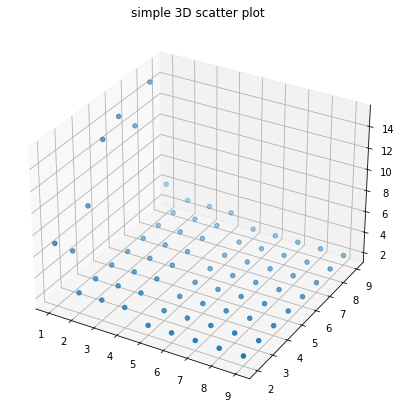

In [35]:
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")

# Creating plot
ax.scatter3D(Leps, Lminpts, Lcluster)
plt.title("simple 3D scatter plot")
 
# show plot
plt.show()

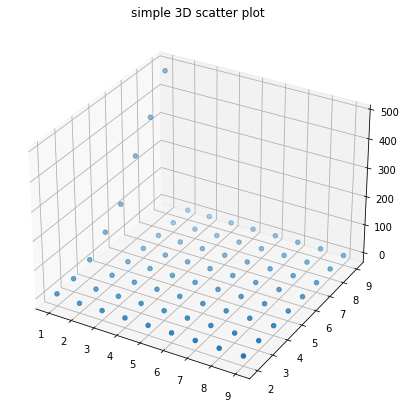

In [36]:
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")

# Creating plot
ax.scatter3D(Leps, Lminpts, Lout)
plt.title("simple 3D scatter plot")
 
# show plot
plt.show()

# DBScan com epslon e pontos escolhido

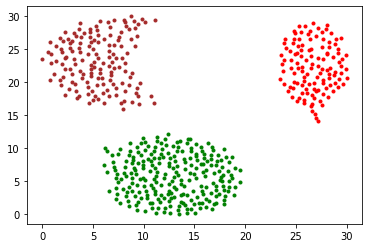

In [37]:
pointlabelDB1,clustersDB1 = DBScan(PointsTrainingDB1,2,2)
plotRes(PointsTrainingDB1, pointlabelDB1, clustersDB1)
plt.show()

# Teste DBScan

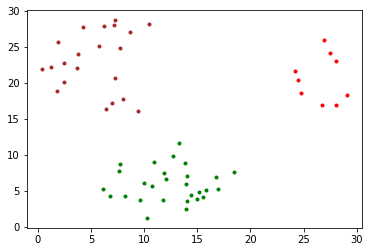

In [38]:

labels_points_test = []

for i in range(len(PointsTestDB1)):
    for j in range(len(PointsTrainingDB1)):
        if np.linalg.norm(PointsTestDB1[i] - PointsTrainingDB1[j]) <= 2:
            labels_points_test.append(pointlabelDB1[j])
            break

plotRes(PointsTestDB1, labels_points_test, clustersDB1)
plt.show()
            

# Validando método de escolher epson e minpts

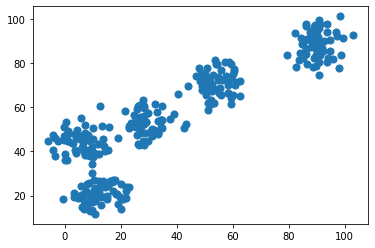

In [39]:
from sklearn.datasets import make_blobs

X, y_true = make_blobs(n_samples=300, centers=5,
                       cluster_std=5,center_box=(0, 100), random_state=3)
plt.scatter(X[:, 0], X[:, 1], s=50)
plt.show()

In [40]:
epss = 10
minptss = 10

Leps = []
Lminpts = []
Lcluster = []
Lout = []

for eps in range(2,epss):
    for minpts in range(2,minptss):
        aux = [0,0,0]
        print('Set eps = ' +str(eps)+ ', Minpoints = '+str(minpts))
        pointlabel,cl = DBScan(X,eps,minpts)
        # plotRes(X, pointlabel, cl)
        # plt.show()
        print('number of cluster found: ' + str(cl-1))
        counter=collections.Counter(pointlabel)
        print(counter)
        outliers  = pointlabel.count(0)
        print('number of outliers found: '+str(outliers) +'\n')
        if(cl-1 < 12):
            Leps.append(eps)
            Lminpts.append(minpts)
            Lcluster.append(cl-1)
            Lout.append(outliers)

Set eps = 2, Minpoints = 2
number of cluster found: 46
Counter({0: 64, 7: 18, 10: 16, 14: 15, 27: 15, 30: 13, 16: 12, 26: 11, 11: 10, 13: 8, 22: 7, 6: 6, 18: 6, 8: 5, 21: 5, 24: 5, 29: 5, 1: 4, 4: 4, 25: 4, 31: 4, 43: 4, 2: 3, 3: 3, 9: 3, 17: 3, 19: 3, 28: 3, 38: 3, 41: 3, 44: 3, 5: 2, 12: 2, 15: 2, 20: 2, 23: 2, 32: 2, 33: 2, 34: 2, 35: 2, 36: 2, 37: 2, 39: 2, 40: 2, 42: 2, 45: 2, 46: 2})
number of outliers found: 64

Set eps = 2, Minpoints = 3
number of cluster found: 30
Counter({0: 96, 3: 18, 6: 16, 10: 15, 20: 15, 23: 13, 11: 12, 19: 11, 7: 10, 9: 8, 16: 7, 12: 6, 13: 6, 4: 5, 15: 5, 17: 5, 22: 5, 1: 4, 8: 4, 18: 4, 24: 4, 29: 4, 27: 3, 2: 3, 5: 3, 25: 3, 14: 3, 21: 3, 26: 3, 28: 3, 30: 3})
number of outliers found: 96

Set eps = 2, Minpoints = 4
number of cluster found: 20
Counter({0: 149, 2: 18, 11: 15, 10: 15, 15: 14, 3: 10, 9: 9, 5: 8, 12: 7, 6: 7, 19: 6, 7: 5, 13: 5, 16: 5, 1: 4, 4: 4, 20: 4, 8: 4, 14: 4, 18: 4, 17: 3})
number of outliers found: 149

Set eps = 2, Minpoints = 5

[4, 4, 4] [7, 8, 9] [5, 5, 5]
[5, 5, 5] [7, 8, 9] [5, 5, 5]


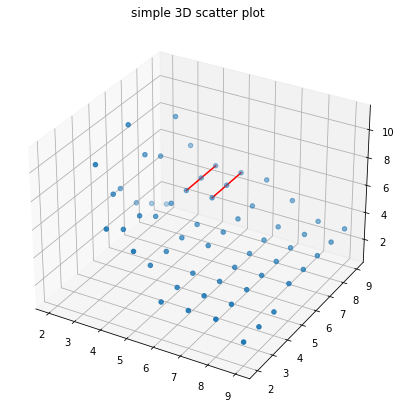

In [41]:
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")

# Creating plot
ax.scatter3D(Leps, Lminpts, Lcluster)
ax.plot(Leps[16:19], Lminpts[16:19], Lcluster[16:19],"r-")
ax.plot(Leps[24:27], Lminpts[24:27], Lcluster[24:27],"r-")
plt.title("simple 3D scatter plot")

print(Leps[16:19], Lminpts[16:19], Lcluster[16:19])
print(Leps[24:27], Lminpts[24:27], Lcluster[24:27])
 
# show plot
plt.show()

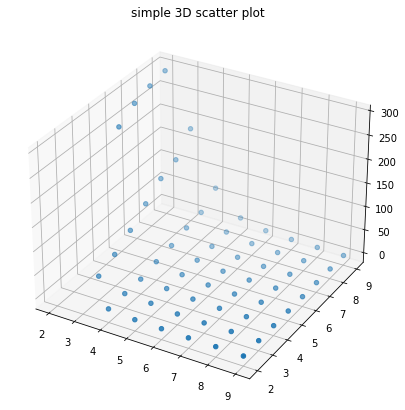

In [42]:
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")

# Creating plot
ax.scatter3D(Leps, Lminpts, Lout)
plt.title("simple 3D scatter plot")
 
# show plot
plt.show()

# Agora com o dataset adiquirido

In [43]:
import csv

with open('countries_of_the_world.csv') as arq:
    
    reader = csv.reader(arq, delimiter=',')

    arq_in = [[x.replace(' ', '') for x in line] for line in reader]
    
    saida = []
    count = 0

    for line in arq_in:
            
        
        if count == 0:
            saida.append(line)
        else:
            if not line.__contains__(''):

                ini = line[:2]

                fim = line[2:]

                aux = [float(x.replace(',','.')) for x in fim]

                lin = ini + aux

                saida.append(lin)
        count+=1    
    
        
    
with open('countries_of_the_world_trimmed.csv', mode='w', newline='') as arq_out:

    writer = csv.writer(arq_out, delimiter=',')
    
    writer.writerows(saida)

In [44]:
with open('countries_of_the_world_trimmed.csv') as arq_in:
    
    count = 0
    reader = csv.reader(arq_in, delimiter=',')

    ini = []
    fim = []

    for line in reader:  

        if count != 0:
            ini.append(line[:2])
            fim.append(line[2:])


        count += 1


    xy = np.array([[float(d) for d in lin] for lin in fim])

# Normalização MinMax

In [45]:
xy = MinMax(xy)

In [46]:
print(xy)

[[ 0.70877761  2.01675521  0.08565496 ... 14.82444733  7.1395881
  10.69506726]
 [ 0.08146772  0.08945747  0.22767162 ...  9.05071521  5.35469108
  17.38789238]
 [ 0.75154361  7.41859121  0.02224804 ...  3.94018205 19.49656751
   7.93721973]
 ...
 [ 0.48957443  1.64444143  0.07193533 ...  5.26657997 15.10297483
  11.132287  ]
 [ 0.26230321  2.34416583  0.02502905 ...  8.58257477  8.85583524
  14.36098655]
 [ 0.27907986  1.21649705  0.0546931  ...  6.98309493  7.24256293
  17.38789238]]


# Data Split

In [47]:
PointsTrainingK2,PointsTestK2 = dataSplit(xy)

# Método cotovelo nosso dataset

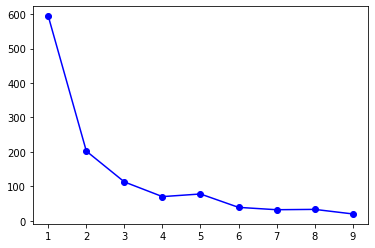

In [48]:

temp_epsilon = []
num_cluster = range(1,10)
for k in num_cluster:
    centers, labels = Kmeans(PointsTrainingK2, k)
    # plt.scatter(Points[:, 0], Points[:, 1], c=labels,s=50, cmap='viridis')
    # plt.show()
    for p in range(k):
        n=0
        for x in centers: 
            z=0
            for i in range(len(labels)):
                if labels[i] == p:
                    # z += np.square(Points[i][0] - x[0]) + np.square(Points[i][1] - x[1])
                    z += np.linalg.norm(PointsTrainingK2[i] - x)**2
                    n+=1   
    temp_epsilon.append(z/n)


plt.plot(num_cluster,temp_epsilon,"bo-")
plt.show()

# Kmeans k = 4 

In [49]:
centersK2, labelsK2 = Kmeans(PointsTrainingK2, 4)

In [50]:
print(centersK2)

[[4.70710417e-01 1.72538950e+00 1.20679142e-01 1.61502002e-01
  1.38311010e+01 6.73902227e+00 4.64343164e+00 2.40461165e+01
  4.21415312e+00 2.39328074e+00 1.36138344e+00 2.67694615e+01
  6.55555556e+00 1.17500000e+01 5.88047323e+00 4.75856090e+00
  1.10518688e+01 1.55388640e+01]
 [5.28800338e-01 1.63217436e+00 1.38153319e-01 1.30562649e-02
  1.45839188e+01 1.64955470e+01 7.10818057e-01 1.40150223e+01
  3.57450344e-01 6.04106925e+00 1.72578829e+00 2.31050069e+01
  8.78378378e+00 2.14148126e+01 1.43967128e+01 1.41760096e+01
  7.09876925e+00 1.13004484e+01]
 [1.20742428e+00 9.37997710e-01 4.23695961e-01 1.36836632e+00
  1.20334331e+01 3.97788056e+00 4.15305874e+00 2.64728597e+01
  6.22400211e+00 1.26807277e+01 6.95020053e+00 1.30826186e+01
  1.56060606e+01 7.03792064e+00 6.36962379e+00 5.23584348e+00
  9.08258789e+00 1.70556461e+01]
 [4.57154084e-01 1.66106959e+00 1.51659091e+00 1.02339155e+00
  1.57457435e+01 1.04304018e+00 1.70596806e+01 2.88175390e+01
  1.64116391e+01 7.03667406e+00 1

In [51]:
print(labelsK2)

[2 0 1 1 0 3 3 3 0 3 2 3 1 0 3 0 3 3 3 0 3 0 1 1 2 1 3 3 1 0 0 0 0 2 2 3 1
 1 2 1 1 2 3 2 1 1 1 0 3 0 2 3 3 1 2 2 3 1 2 3 0 1 0 1 3 1 1 3 2 1 3 1 0 3
 0 1 3 1 0 1 3 0 0 2 3 3 3 0 2 0 3 1 0 3 2 0 0 2 0 3 2 1 3 1 2 0 0 2 2 3 0
 2 1 0 3 0 0 1 0 0 0 3 2 2 0 3 2 0 2 2 3 1 1 1 0 3 2 3 2 1 3 3 3 3 1 0 0 0
 0 0 0 1 2 3 1 2 0 2 3 2 3]


# Kmeans K = 3

In [52]:
centersK2n3, labelsK2n3 = Kmeans(PointsTrainingK2, 3)

In [53]:
print(centersK2n3)

[[4.05491709e-01 1.16195891e+00 2.53406382e-01 1.11047570e+00
  1.31172421e+01 4.37373851e+00 5.03978206e+00 2.55277169e+01
  5.71019481e+00 4.10063311e+00 4.53619149e+00 2.28477528e+01
  8.62903226e+00 9.41120121e+00 4.25657732e+00 4.85695709e+00
  9.22344431e+00 1.72381745e+01]
 [1.04498292e+00 1.68248019e+00 1.69251199e-01 1.34883307e-02
  1.44622588e+01 1.56065353e+01 8.83042895e-01 1.53322209e+01
  4.69759412e-01 6.30564724e+00 1.50914011e+00 2.30175679e+01
  8.54166667e+00 2.03762373e+01 1.36990029e+01 1.22317945e+01
  8.39316362e+00 1.17075392e+01]
 [5.16117733e-01 1.81560006e+00 1.38141431e+00 5.97761536e-01
  1.52147960e+01 1.42266012e+00 1.57293802e+01 2.90426899e+01
  1.54237155e+01 1.01266254e+01 1.16757978e+00 1.97085734e+01
  1.76470588e+01 3.23732532e+00 6.97186888e+00 1.77235524e+00
  7.99838471e+00 2.11059087e+01]]


In [54]:
print(labelsK2n3)

[2 0 1 1 0 2 0 2 0 2 0 2 1 0 2 0 0 2 2 0 0 0 1 1 0 1 2 2 1 0 0 0 1 2 0 2 1
 1 0 1 1 0 2 0 1 1 1 0 2 0 0 0 2 1 0 1 0 1 0 2 0 1 0 1 2 1 1 2 2 1 0 1 0 2
 0 1 2 1 0 1 2 0 1 2 2 2 2 1 0 1 2 1 0 2 2 0 0 0 1 0 0 1 2 1 0 0 0 0 2 2 0
 0 1 0 2 0 0 1 0 0 0 2 2 0 0 2 2 1 0 2 2 1 1 1 0 2 2 2 2 1 2 2 2 2 1 1 1 1
 0 0 0 1 0 2 1 2 0 1 2 0 2]


# DBScan no nosso dataset

In [55]:
PointsTrainingDB2,PointsTestDB2 = dataSplit(xy)

In [56]:
epss = 20
minptss = 10

Leps = []
Lminpts = []
Lcluster = []
Lout =[]

for eps in range(1,epss):
    for minpts in range(2,minptss):
        print('Set eps = ' +str(eps)+ ', Minpoints = '+str(minpts))
        pointlabeldb2,clustersDB2 = DBScan(PointsTrainingDB2,eps,minpts)
        print('number of cluster found: ' + str(clustersDB2-1))
        counter=collections.Counter(pointlabeldb2)
        print(counter)
        outliers  = pointlabeldb2.count(0)
        print('number of outliers found: '+str(outliers) +'\n')
        if clustersDB2 < 8:
            Leps.append(eps)
            Lminpts.append(minpts)
            Lcluster.append(clustersDB2-1)
            Lout.append(outliers)



Set eps = 1, Minpoints = 2
number of cluster found: 0
Counter({0: 161})
number of outliers found: 161

Set eps = 1, Minpoints = 3
number of cluster found: 0
Counter({0: 161})
number of outliers found: 161

Set eps = 1, Minpoints = 4
number of cluster found: 0
Counter({0: 161})
number of outliers found: 161

Set eps = 1, Minpoints = 5
number of cluster found: 0
Counter({0: 161})
number of outliers found: 161

Set eps = 1, Minpoints = 6
number of cluster found: 0
Counter({0: 161})
number of outliers found: 161

Set eps = 1, Minpoints = 7
number of cluster found: 0
Counter({0: 161})
number of outliers found: 161

Set eps = 1, Minpoints = 8
number of cluster found: 0
Counter({0: 161})
number of outliers found: 161

Set eps = 1, Minpoints = 9
number of cluster found: 0
Counter({0: 161})
number of outliers found: 161

Set eps = 2, Minpoints = 2
number of cluster found: 0
Counter({0: 161})
number of outliers found: 161

Set eps = 2, Minpoints = 3
number of cluster found: 0
Counter({0: 161})
n

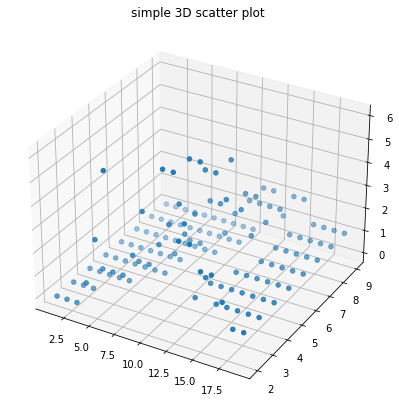

In [57]:
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")

# Creating plot
ax.scatter3D(Leps, Lminpts, Lcluster)
plt.title("simple 3D scatter plot")
 
# show plot
plt.show()

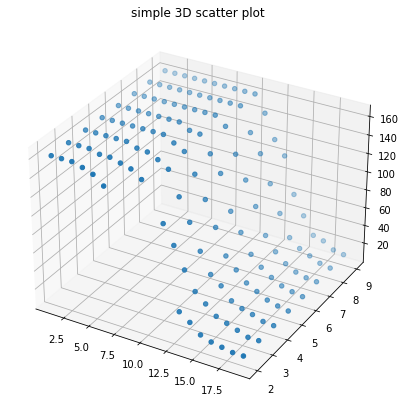

In [58]:
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")

# Creating plot
ax.scatter3D(Leps, Lminpts, Lout)
plt.title("simple 3D scatter plot")
 
# show plot
plt.show()

# PCA

In [59]:
from sklearn.decomposition import PCA
# Make an instance of the Model
pca = PCA(.95)

In [60]:
PointsTrainingPCA,PointsTestPCA = dataSplit(xy)

## Aplica PCA

In [61]:
pca.fit(PointsTrainingPCA)
PointsTrainingPCA = pca.transform(PointsTrainingPCA)
PointsTestPCA = pca.transform(PointsTestPCA)

## Cotovelo com PCA

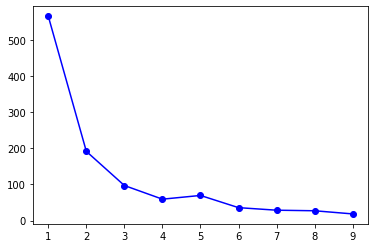

In [62]:
temp_epsilon = []
num_cluster = range(1,10)
for k in num_cluster:
    centers, labels = Kmeans(PointsTrainingPCA, k)
    # plt.scatter(PointsTrainingPCA[:, 0], PointsTrainingPCA[:, 1], c=labels,s=50, cmap='viridis')
    # plt.show()
    for p in range(k):
        n=0
        for x in centers: 
            z=0
            for i in range(len(labels)):
                if labels[i] == p:
                    # z += np.square(PointsTrainingPCA[i][0] - x[0]) + np.square(PointsTrainingPCA[i][1] - x[1])
                    z += np.linalg.norm(PointsTrainingPCA[i] - x)**2
                    n+=1   
    temp_epsilon.append(z/n)


plt.plot(num_cluster,temp_epsilon,"bo-")
plt.show()

## Kmeans com PCA

In [63]:
centersPCA, labelsPCA = Kmeans(PointsTrainingPCA, 3)

In [64]:
print(centersPCA)

[[-1.60716253e+00 -2.21437866e+00  6.07596760e+00  1.98098848e+00
  -7.13141274e-01 -2.22186679e-01 -3.88511723e-01  1.99646871e-01
   3.04418395e-01  1.14979990e-02]
 [ 2.01621493e+01  1.36505351e+00 -3.76112969e+00 -1.12484519e+00
   5.41262406e-01  9.83304749e-02  2.09414153e-01 -4.23111726e-01
   8.62481908e-02 -1.88838011e-02]
 [-1.91711433e+01  1.72307324e+00 -4.71127189e+00 -1.64408316e+00
   4.46640569e-01  2.14046250e-01  3.34358265e-01  1.64256110e-01
  -5.28647292e-01  3.61822440e-03]]


In [65]:
print(labelsPCA)

[2 0 1 1 0 2 0 2 0 2 0 2 1 0 2 0 0 2 2 0 0 1 1 1 0 1 2 2 1 0 0 0 1 0 0 2 1
 1 0 1 1 0 2 0 1 1 1 0 2 0 0 0 0 1 0 1 0 1 0 2 0 1 0 1 2 1 1 2 2 1 0 1 0 2
 0 1 2 1 0 1 2 0 1 2 2 2 2 1 0 1 2 1 0 2 0 0 0 0 1 0 0 1 2 1 0 0 0 0 2 2 0
 0 1 0 2 0 0 1 0 0 0 0 2 0 0 2 2 1 0 0 2 1 1 1 0 2 2 2 2 1 2 2 2 2 1 1 1 1
 0 0 0 1 0 2 1 2 0 1 2 0 2]


In [66]:
 print(labelsK2n3 == labelsPCA)

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True False  True  True
  True  True  True  True  True  True  True  True  True False  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True False  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True False  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True False  True  True  True  True  True  True  True False  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True]


In [67]:
print(labelsK2n3)

[2 0 1 1 0 2 0 2 0 2 0 2 1 0 2 0 0 2 2 0 0 0 1 1 0 1 2 2 1 0 0 0 1 2 0 2 1
 1 0 1 1 0 2 0 1 1 1 0 2 0 0 0 2 1 0 1 0 1 0 2 0 1 0 1 2 1 1 2 2 1 0 1 0 2
 0 1 2 1 0 1 2 0 1 2 2 2 2 1 0 1 2 1 0 2 2 0 0 0 1 0 0 1 2 1 0 0 0 0 2 2 0
 0 1 0 2 0 0 1 0 0 0 2 2 0 0 2 2 1 0 2 2 1 1 1 0 2 2 2 2 1 2 2 2 2 1 1 1 1
 0 0 0 1 0 2 1 2 0 1 2 0 2]
